In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from   torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import io
import cv2
import math
import torchvision.models as models



In [2]:
class MDKModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_7x7_r,f_7x7):
        super(MDKModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_1x1, kernel_size=1, stride=1, padding=0,dilation=1)
        )
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=3, stride=1, padding=1,dilation=1),
            ConvBlock(f_3x3_r, f_3x3, kernel_size=3, stride=1, padding=1,dilation=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, f_5x5_r, kernel_size=3, stride=1, padding=2,dilation=2),
            ConvBlock(f_5x5_r, f_5x5, kernel_size=3, stride=1, padding=2,dilation=2)
        )
        
        self.branch4 = nn.Sequential(
            ConvBlock(in_channels, f_7x7_r, kernel_size=3, stride=1, padding=4,dilation=4),
            ConvBlock(f_7x7_r, f_7x7, kernel_size=3, stride=1, padding=4,dilation=4)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [3]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,dilation):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,dilation)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [4]:
class MDKResNet(nn.Module):
    
    def __init__(self, num_classes = 12):
        super(MDKResNet, self).__init__()
        self.bn = nn.BatchNorm2d(544)
        self.conv1 = ConvBlock(6, 64, kernel_size=7, stride=2, padding=3,dilation=1)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0,dilation=1)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1,dilation=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception3A = MDKModule(in_channels=6,
                                           f_1x1=64,
                                           f_3x3_r=32,   #2
                                           f_3x3=64,
                                           f_5x5_r=32,  #6
                                           f_5x5=64,   
                                           f_7x7_r=32,    #12
                                          f_7x7=64)
        self.inception3B = MDKModule(in_channels=256,
                                           f_1x1=128,
                                           f_3x3_r=64,
                                           f_3x3=128,
                                           f_5x5_r=64,
                                           f_5x5=128,
                                           f_7x7_r=64,
                                          f_7x7=128)
        self.inception4A = MDKModule(in_channels=512,
                                           f_1x1=256,
                                           f_3x3_r=128,
                                           f_3x3=256,
                                           f_5x5_r=128,
                                           f_5x5=256,
                                           f_7x7_r=128,
                                           f_7x7=256)
        self.inception4B = MDKModule(in_channels=1024,
                                           f_1x1=512,
                                           f_3x3_r=256,
                                           f_3x3=512,
                                           f_5x5_r=256,
                                           f_5x5=512,
                                           f_7x7_r=256,
                                           f_7x7=512)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(2048, num_classes)
        self.bn = nn.BatchNorm2d(544)

    def forward(self, x):
       
        
        
   
        x= self.inception3A(x)
        x = self.pool3(x)
        x = self.inception3B(x)
        x = self.pool3(x)
        x = self.inception4A(x)
        x = self.pool3(x)
        x = self.inception4B(x)
        x = self.pool6(x)
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x =self.fc(x)

        return x
      
        
        
    


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [6]:
model = MDKResNet()
#model = nn.DataParallel(model)


model = model.to(device)
 


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from   torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
random_seed = 611
np.random.seed(random_seed)

# matplotlib inline
plt.style.use('ggplot')

segments = np.load("/home/kitahara/segments_myorigin64_v1021.npy",allow_pickle=True)
labels = np.load("/home/kitahara/labels_myorigin64_v1021.npy")

labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)

labels_trans=[]
for l in range(len(labels)):
  select = np.where(labels[l]==1)
  labels_trans.append(select)
labels_trans = np.asarray(labels_trans)  
#labels_trans = labels_trans.flatten()
y_trans = []
for i in range(len(labels)):
  y_trans.append(labels_trans[i][0][0])

target = np.array(y_trans)



In [8]:
acc_x = segments[:,:,0]
acc_y =segments[:,:,1]
acc_z = segments[:,:,2]

In [9]:
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

In [10]:
def transfer(array):
  gasf = GramianAngularField(method='summation')
  gasf = gasf.fit_transform(array)
  #mtf = MarkovTransitionField(image_size=64)
  #mtf = mtf.fit_transform(array)
  gadf = GramianAngularField(method='difference')
  gadf = gadf.fit_transform(array)
  return gasf,gadf

In [11]:
x_gasf,x_gadf= transfer(acc_x)
y_gasf,y_gadf = transfer(acc_y)
z_gasf,z_gadf = transfer(acc_z)

In [12]:
x_sf = x_gasf.reshape(x_gasf.shape[0],1,x_gasf.shape[1],x_gasf.shape[2])

In [13]:
x_sf.shape

(9468, 1, 64, 64)

In [14]:
x_df = x_gadf.reshape(x_gadf.shape[0],1,x_gadf.shape[1],x_gadf.shape[2])
y_sf = y_gasf.reshape(y_gasf.shape[0],1,y_gasf.shape[1],y_gasf.shape[2])
y_df = y_gadf.reshape(y_gadf.shape[0],1,y_gadf.shape[1],y_gadf.shape[2])
z_sf = z_gasf.reshape(z_gasf.shape[0],1,z_gasf.shape[1],z_gasf.shape[2])
z_df = z_gadf.reshape(z_gadf.shape[0],1,z_gadf.shape[1],z_gadf.shape[2])

In [15]:
"""R = np.hstack([x_gasf,x_gadf])
G = np.hstack([y_gasf,y_gadf])
B = np.hstack([z_gasf,z_gadf])

R = R.reshape(R.shape[0],1,R.shape[1],R.shape[2])
G = G.reshape(G.shape[0],1,G.shape[1],G.shape[2])
B = B.reshape(B.shape[0],1,B.shape[1],B.shape[2])

RGB = np.hstack([R,G,B])

X = RGB"""


'R = np.hstack([x_gasf,x_gadf])\nG = np.hstack([y_gasf,y_gadf])\nB = np.hstack([z_gasf,z_gadf])\n\nR = R.reshape(R.shape[0],1,R.shape[1],R.shape[2])\nG = G.reshape(G.shape[0],1,G.shape[1],G.shape[2])\nB = B.reshape(B.shape[0],1,B.shape[1],B.shape[2])\n\nRGB = np.hstack([R,G,B])\n\nX = RGB'

In [16]:
#R_gasf = x_gasf.reshape(x_gasf.shape[0],1,x_gasf.shape[1],x_gasf.shape[2])
#G_gasf = y_gasf.reshape(y_gasf.shape[0],1,y_gasf.shape[1],y_gasf.shape[2])
#B_gasf = z_gasf.reshape(z_gasf.shape[0],1,z_gasf.shape[1],z_gasf.shape[2])

In [17]:
#RGB_gasf = np.hstack([R_gasf,G_gasf,B_gasf])

In [18]:
#RGB_gasf.shape

In [19]:
"""R_gadf = x_gadf.reshape(x_gadf.shape[0],1,x_gadf.shape[1],x_gadf.shape[2])
G_gadf = y_gadf.reshape(y_gadf.shape[0],1,y_gadf.shape[1],y_gadf.shape[2])
B_gadf = z_gadf.reshape(z_gadf.shape[0],1,z_gadf.shape[1],z_gadf.shape[2])"""

'R_gadf = x_gadf.reshape(x_gadf.shape[0],1,x_gadf.shape[1],x_gadf.shape[2])\nG_gadf = y_gadf.reshape(y_gadf.shape[0],1,y_gadf.shape[1],y_gadf.shape[2])\nB_gadf = z_gadf.reshape(z_gadf.shape[0],1,z_gadf.shape[1],z_gadf.shape[2])'

In [20]:
#RGB_gadf = np.hstack([R_gadf,G_gadf,B_gadf])

In [21]:
#re_target = np.hstack([target,target])

In [22]:
#X = np.vstack([RGB_gasf,RGB_gadf])

In [23]:
X = np.hstack([x_sf,x_df,y_sf,y_df,z_sf,z_df])

In [24]:
X.shape

(9468, 6, 64, 64)

In [25]:
#re_target.shape

In [26]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [27]:
dataset = MyDataset(X, target)



n_samples = len(dataset) # n_samples is 60000
train_size = int(len(dataset) * 0.6) # train_size is 48000
val_size = int(len(dataset) * 0.2)
test_size = n_samples - train_size-val_size # val_size is 48000

# shuffleしてから分割してくれる.
train_dataset, val_dataset ,test_dataset= torch.utils.data.random_split(dataset, [train_size, val_size,test_size])



In [28]:

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size, shuffle=False, num_workers=2)

#dataloaders_dict = {"train": training_loader, "val": validation_loader}

In [29]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=10, verbose=False, path='checkpoint_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

In [30]:


criterion = nn.CrossEntropyLoss()
#変更
optimizer = optim.Adam(model.parameters(),lr=0.001)

epochs = 100
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=10, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(train_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(val_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(train_loader.dataset)
  epoch_acc = running_corrects.float()/ len(train_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(val_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(val_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
   print("Early stopping")
   break
#学習済みモデルの保存
save_path = './mdkres_myorigin_1021_hiss.pth'
torch.save(model.state_dict(), save_path)

  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 1
training loss: 0.0388, training acc 0.7886
validation loss: 0.0217, validation acc0.8785
Validation loss decreased (inf --> 0.021732).  Saving model ...


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 2
training loss: 0.0139, training acc 0.9250
validation loss: 0.0305, validation acc0.8447
EarlyStopping counter: 1 out of 10


100%|██████████| 119/119 [00:03<00:00, 36.25it/s]


epoch * 3
training loss: 0.0091, training acc 0.9528
validation loss: 0.0058, validation acc0.9720
Validation loss decreased (0.021732 --> 0.005761).  Saving model ...


100%|██████████| 119/119 [00:03<00:00, 36.00it/s]


epoch * 4
training loss: 0.0061, training acc 0.9667
validation loss: 0.0028, validation acc0.9857
Validation loss decreased (0.005761 --> 0.002763).  Saving model ...


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 5
training loss: 0.0047, training acc 0.9762
validation loss: 0.0045, validation acc0.9794
EarlyStopping counter: 1 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 6
training loss: 0.0039, training acc 0.9785
validation loss: 0.0028, validation acc0.9857
EarlyStopping counter: 2 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 7
training loss: 0.0061, training acc 0.9710
validation loss: 0.0076, validation acc0.9678
EarlyStopping counter: 3 out of 10


100%|██████████| 119/119 [00:03<00:00, 38.53it/s]


epoch * 8
training loss: 0.0030, training acc 0.9850
validation loss: 0.0027, validation acc0.9820
Validation loss decreased (0.002763 --> 0.002730).  Saving model ...


100%|██████████| 119/119 [00:03<00:00, 36.21it/s]


epoch * 9
training loss: 0.0038, training acc 0.9803
validation loss: 0.0020, validation acc0.9894
Validation loss decreased (0.002730 --> 0.002033).  Saving model ...


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 10
training loss: 0.0030, training acc 0.9850
validation loss: 0.0028, validation acc0.9831
EarlyStopping counter: 1 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 11
training loss: 0.0019, training acc 0.9908
validation loss: 0.0042, validation acc0.9820
EarlyStopping counter: 2 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 12
training loss: 0.0045, training acc 0.9769
validation loss: 0.0040, validation acc0.9789
EarlyStopping counter: 3 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 13
training loss: 0.0023, training acc 0.9898
validation loss: 0.0030, validation acc0.9847
EarlyStopping counter: 4 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 14
training loss: 0.0029, training acc 0.9880
validation loss: 0.0059, validation acc0.9757
EarlyStopping counter: 5 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 15
training loss: 0.0025, training acc 0.9863
validation loss: 0.0033, validation acc0.9868
EarlyStopping counter: 6 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 16
training loss: 0.0016, training acc 0.9919
validation loss: 0.0043, validation acc0.9789
EarlyStopping counter: 7 out of 10


100%|██████████| 119/119 [00:02<00:00, 39.76it/s]


epoch * 17
training loss: 0.0021, training acc 0.9896
validation loss: 0.0018, validation acc0.9894
Validation loss decreased (0.002033 --> 0.001837).  Saving model ...


100%|██████████| 119/119 [00:02<00:00, 40.38it/s]


epoch * 18
training loss: 0.0024, training acc 0.9894
validation loss: 0.0016, validation acc0.9931
Validation loss decreased (0.001837 --> 0.001584).  Saving model ...


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 19
training loss: 0.0013, training acc 0.9937
validation loss: 0.0208, validation acc0.9218
EarlyStopping counter: 1 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 20
training loss: 0.0027, training acc 0.9868
validation loss: 0.0091, validation acc0.9757
EarlyStopping counter: 2 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 21
training loss: 0.0038, training acc 0.9817
validation loss: 0.0027, validation acc0.9921
EarlyStopping counter: 3 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 22
training loss: 0.0014, training acc 0.9928
validation loss: 0.0018, validation acc0.9921
EarlyStopping counter: 4 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 23
training loss: 0.0022, training acc 0.9917
validation loss: 0.0027, validation acc0.9868
EarlyStopping counter: 5 out of 10


100%|██████████| 119/119 [00:03<00:00, 36.45it/s]


epoch * 24
training loss: 0.0010, training acc 0.9961
validation loss: 0.0016, validation acc0.9910
Validation loss decreased (0.001584 --> 0.001551).  Saving model ...


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 25
training loss: 0.0004, training acc 0.9975
validation loss: 0.0037, validation acc0.9878
EarlyStopping counter: 1 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 26
training loss: 0.0012, training acc 0.9938
validation loss: 0.0025, validation acc0.9884
EarlyStopping counter: 2 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 27
training loss: 0.0022, training acc 0.9919
validation loss: 0.0048, validation acc0.9857
EarlyStopping counter: 3 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 28
training loss: 0.0024, training acc 0.9908
validation loss: 0.0023, validation acc0.9889
EarlyStopping counter: 4 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 29
training loss: 0.0008, training acc 0.9967
validation loss: 0.0022, validation acc0.9921
EarlyStopping counter: 5 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 30
training loss: 0.0004, training acc 0.9975
validation loss: 0.0026, validation acc0.9873
EarlyStopping counter: 6 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 31
training loss: 0.0012, training acc 0.9928
validation loss: 0.0027, validation acc0.9900
EarlyStopping counter: 7 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 32
training loss: 0.0013, training acc 0.9942
validation loss: 0.0020, validation acc0.9921
EarlyStopping counter: 8 out of 10


  0%|          | 0/355 [00:00<?, ?it/s]

epoch * 33
training loss: 0.0015, training acc 0.9940
validation loss: 0.0019, validation acc0.9926
EarlyStopping counter: 9 out of 10


100%|██████████| 119/119 [00:03<00:00, 36.65it/s]

epoch * 34
training loss: 0.0010, training acc 0.9952
validation loss: 0.0022, validation acc0.9905
EarlyStopping counter: 10 out of 10
Early stopping


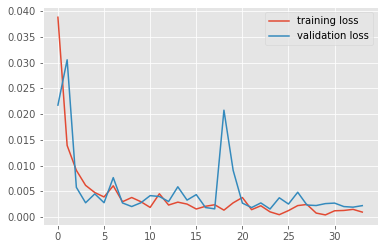

In [31]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

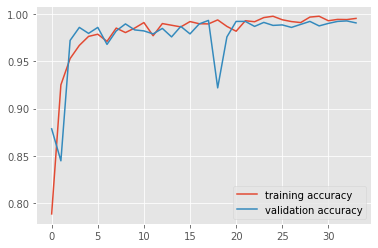

In [32]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [33]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [34]:
model.load_state_dict(torch.load("mdkres_myorigin_1021_hiss.pth"))

<All keys matched successfully>

In [35]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1, shuffle=False, num_workers=2)

In [36]:
y_true=[]
for inputs, labels in tqdm(test_dataset):
    
    y_true.append(str(int(labels)))
    

100%|██████████| 1895/1895 [00:00<00:00, 117157.60it/s]


In [37]:
model.eval()  # ネットワークを推論モードに切り替える

y_pred = []
# データローダーから1ミニバッチずつ取り出して計算する
for inputs, labels in tqdm(test_loader):
    #data, target,id = Variable(data), Variable(target), Variable(id) # 微分可能に変換
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    output= model(inputs)  # 入力dataをinputし、出力を求める

    # 推論する
    #pred = output1.data.max(1, keepdim=True)[1]  # 出力ラベルを求める
    _1, pred = torch.max(output, 1)
    y_pred.append(str(int(pred)))
   
        

100%|██████████| 1895/1895 [00:19<00:00, 99.08it/s] 


In [38]:
from sklearn.metrics import recall_score, precision_score, f1_score,accuracy_score
average = "macro"

In [39]:
print(recall_score(y_true=y_true, y_pred=y_pred, average=average))

0.9848231934846665


In [45]:
print(accuracy_score(y_true=y_true, y_pred=y_pred))

0.9889182058047493


In [40]:
print(precision_score(y_true=y_true, y_pred=y_pred, average=average))

0.9849811362199246


In [41]:
print(f1_score(y_true=y_true, y_pred=y_pred, average=average))

0.9845747608006202


In [42]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[ 72   1   0   0   0   0   1   0   0   0   0   0]
 [  0 101   0   0   0   1   2   0   0   0   0   0]
 [  0   0 106   1   0   0   0   0   0   0   0   9]
 [  0   0   0 203   0   0   0   0   0   0   0   0]
 [  0   0   0   0 267   0   0   0   0   0   0   0]
 [  0   1   0   0   0  95   0   0   0   0   0   0]
 [  1   0   0   0   0   0 114   0   0   0   0   0]
 [  0   0   0   0   0   0   0 171   0   0   0   0]
 [  0   0   0   0   0   0   0   0 203   2   0   0]
 [  0   0   0   0   0   0   1   0   1 177   0   0]
 [  0   0   0   0   0   0   0   0   0   0 264   0]
 [  0   0   0   0   0   0   0   0   0   0   0 101]]


In [46]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=["backdown","backup","backwalk","frontdown","frontup","frontwalk","smadown","smaup","smawalk","udedown","udeup","udewalk"], columns=["backdown","backup","backwalk","frontdown","frontup","frontwalk","smadown","smaup","smawalk","udedown","udeup","udewalk"])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True,fmt='d')
    plt.show()

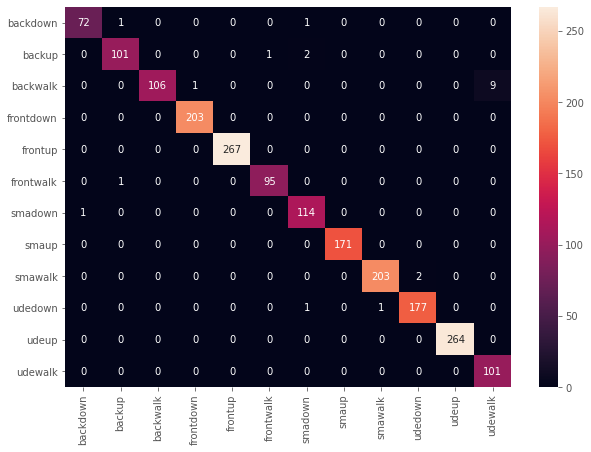

In [47]:
print_cmx(y_true,y_pred)